In [1]:
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv("municipality_bus_utilization.csv")

In [3]:
data.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [4]:
data.describe()

,municipality_id,usage,total_capacity
count,13070.000000,13070.000000,13070.000000
mean,4.500000,876.002984,1972.800000
std,2.872391,679.287109,1144.074782
min,0.000000,11.000000,397.000000
25%,2.000000,403.000000,697.000000
50%,4.500000,692.000000,1974.500000
75%,7.000000,1190.000000,2947.000000
max,9.000000,3508.000000,3893.000000


In [5]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.sort_values("timestamp")

In [6]:
data.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [7]:
# aggregation for duplicated hours, keys are timestamp and municipality_id
hourly_data = data.groupby([pd.Grouper(key="timestamp", freq="H"), pd.Grouper("municipality_id")]).usage.max().reset_index()
hourly_data.head()

,timestamp,municipality_id,usage
0,2017-06-04 07:00:00,0,204
1,2017-06-04 07:00:00,1,129
2,2017-06-04 07:00:00,2,273
3,2017-06-04 07:00:00,3,623
4,2017-06-04 07:00:00,4,1090


# Visualization

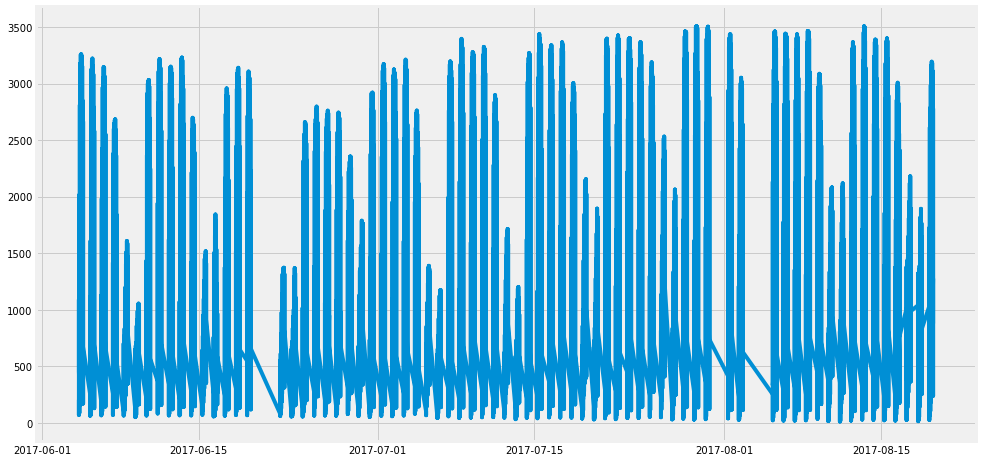

In [8]:
plt.figure(figsize=(15,8))

# plotting the graph
plt.plot(hourly_data.timestamp, hourly_data.usage)
plt.show()

In [9]:
# split data as train and test sets
hourly_data['year'] = hourly_data['timestamp'].dt.year
hourly_data['month'] = hourly_data['timestamp'].dt.month
hourly_data['day'] = hourly_data['timestamp'].dt.day
hourly_data['dayofweek'] = hourly_data['timestamp'].dt.dayofweek
hourly_data['hour'] = hourly_data['timestamp'].dt.hour
train_data = hourly_data[hourly_data["timestamp"] < dt(2017, 8, 5)]
test_data = hourly_data[hourly_data["timestamp"] >= dt(2017, 8, 5)]
train_data.set_index("timestamp", inplace=True)
test_data.set_index("timestamp", inplace=True)

In [10]:
train_data.shape

(5320, 7)

In [11]:
test_data.shape

(1420, 7)

# Classical Machine Learning Models

In [12]:
def create_classical_model(model, model_name, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    print('MAE: {} for {}'.format(mean_absolute_error(y_test, predictions), model_name))

In [13]:
x_train, y_train, x_test, y_test = train_data.drop(['usage'], axis = 1), train_data['usage'], test_data.drop(['usage'], axis = 1), test_data['usage']
create_classical_model(XGBRegressor(), "xgboost regressor", x_train, y_train, x_test, y_test)
create_classical_model(XGBClassifier(), "xgboost classifier", x_train, y_train, x_test, y_test)
create_classical_model(LinearRegression(), "linear regressor", x_train, y_train, x_test, y_test)
create_classical_model(DecisionTreeClassifier(), "decision tree", x_train, y_train, x_test, y_test)
create_classical_model(KNeighborsClassifier(10), "knn", x_train, y_train, x_test, y_test)

MAE: 178.85659359775903 for xgboost regressor


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:46] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1636469955450/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
MAE: 254.18873239436618 for xgboost classifier
MAE: 479.77120123173086 for linear regressor
MAE: 188.7767605633803 for decision tree
MAE: 578.3422535211267 for knn


# Autoregressive Moving Average (ARIMA)


In [14]:
def crete_arima_model(data, forecasting_date="2017-08-05", year="2017"):
    """ retreived from: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3"""
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data.asfreq(freq='1h'),
                                                exog=None,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()

    print(results.summary().tables[1])

    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    pred = results.get_prediction(start=pd.to_datetime(forecasting_date), dynamic=False)
    pred_ci = pred.conf_int()
    ax = data[year:].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Usage')
    plt.legend()

    plt.show()

In [15]:
def create_municipality_based_data(mun_id):
    """ resampling and filling parts retreived from: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3"""

    mun_data = hourly_data[hourly_data["municipality_id"] == mun_id]
    mun_data.head()
    mun_data.set_index("timestamp", inplace=True)
    mun_data = mun_data.resample('H').mean()

    # The term bfill means that we use the value before filling in missing values
    mun_data = mun_data.fillna(mun_data.bfill())
    return mun_data.drop(["municipality_id"], axis=1)

In [16]:
hourly_data = hourly_data.loc[:, 'timestamp':'usage']
hourly_data.head()

,timestamp,municipality_id,usage
0,2017-06-04 07:00:00,0,204
1,2017-06-04 07:00:00,1,129
2,2017-06-04 07:00:00,2,273
3,2017-06-04 07:00:00,3,623
4,2017-06-04 07:00:00,4,1090


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:27637.58770404714
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:26936.17925969458
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:26101.753030520595
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:24613.203850860365
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:25915.333367734922
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:24769.38217589751
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:23581.91891534514
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:23460.377628663857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53424D+00    |proj g|=  9.57812D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segment

ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:24945.22042205988
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:24415.75498749181
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:22952.018688053704
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:24181.967005647493
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:23098.892880723433
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:22188.933415260093
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:22122.56128600405
    2     23     39      1     0     0   2.919D-05   6.965D+00
  F =   6.9648949930309882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.24406D+00    |proj g|=  6.94180D-01

At iterate    5    f=  7.08843D+00    |proj g|=  1.64541D-03

At iterate   10    f=  7.08765D+00    |proj g|=  3.20738D-02

At iterate   15    f=  7.04753D+00    |proj g|=  2.73708D-01

At iterate   20    f=  6.81992D+00    

ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:21720.729162088162
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:22983.916653566157
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:21072.499302991266
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:21731.661155626738
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:21207.453208402934
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:20874.890777838067
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:20757.049324743595
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:21745.320354401618
At iterate    0    f=  5.95903D+00    |proj g|=  9.11449D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.114D-07   5.959D+00
  F =   

ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:22870.56064476461
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:20995.891993246958
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:21632.01130608883
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:21130.197112420796
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:20875.86299650509
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:20735.653231694618
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:21858.281796356456
At iterate    0    f=  5.89123D+00    |proj g|=  5.06970D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      8      1     0     0   4.877D-05   5.890D+00
  F =   5.8899308672717225     

CONVERGENCE: REL_REDUCTION_OF_F_<=

ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:22914.06532855075
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:21038.041188322793
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:21717.37662452994
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:21180.427408204185
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:20772.500436188682
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:20701.237722552793
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:21736.923989082134
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:21599.28433348433
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24593D+00    |proj g|=  2.86061D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:20944.205810230975
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:21610.007625851355
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:21086.38547615423
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:20763.548462211187
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:20673.602266824317
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:21735.56946478574
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:21599.1565603434
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   9.327D-05   6.206D+00
  F =   6.2055563478288143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 var

ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:22861.58806593473
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:20995.708241657983
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:21599.15232991373
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:21130.977736427627
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:20865.20625045984
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:20745.832846147205
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:21720.97303995397
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:21586.4476019735
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:22844.809278427205
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.315D-06   6.232D+00
  F =   6.2316216101239723     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.8

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:20983.08903815385
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:21597.30840645371
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:21117.8980272015
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:20848.87607917198
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:20743.334157883255
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9251      0.051    -18.245      0.000      -1.024      -0.826
ma.L1          1.1111      0.068     16.247      0.000       0.977       1.245
ar.S.L12      -0.5480      0.010    -56.892      0.000      -0.567      -0.529
ma.S.L12      -0.7044      0.010    -69.854      0.000      -0.724      -0.685
sigma2      4540.9848    563.198      8.063      0.000    3437.137    5644.833


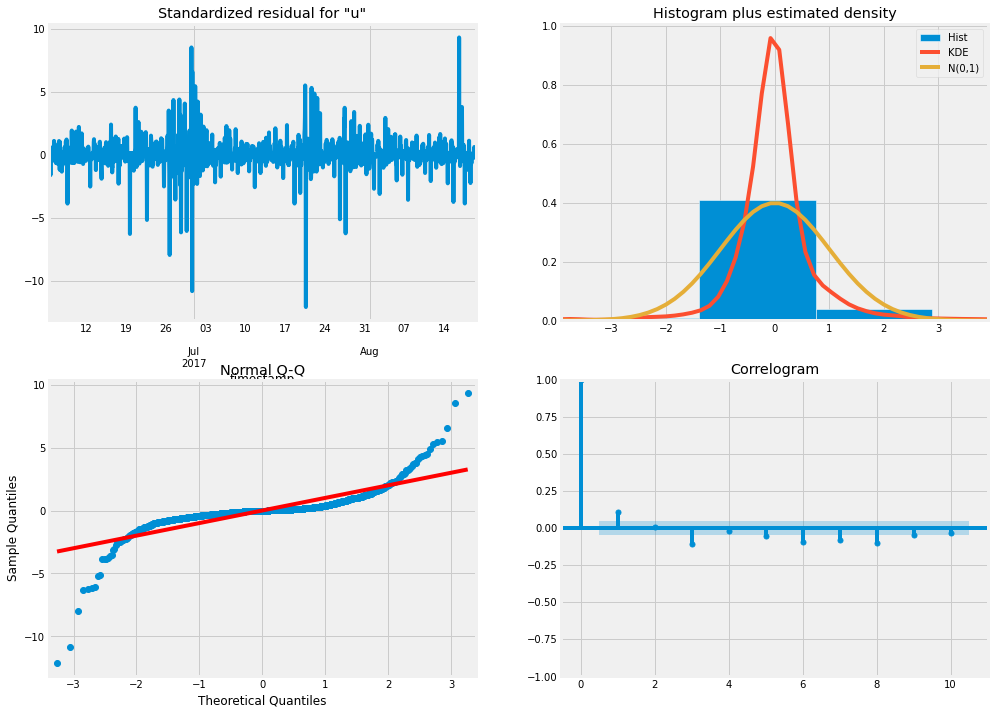

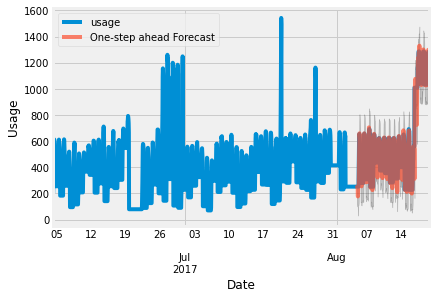

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:25146.654468385805
Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89256D+00    |proj g|=  7.77285D-02

At iterate    5    f=  5.88941D+00    |proj g|=  6.96603D-03

At iterate   10    f=  5.86456D+00    |proj g|=  9.58599D-02

At iterate   15    f=  5.85363D+00    |proj g|=  4.21818D-02

At iterate   20    f=  5.74624D+00    |proj g|=  2.61748D-01

At iterate   25    f=  5.72106D+00    |proj g|=  7.69527D-02

At iterate   30    f=  5.71840D+00    |proj g|=  1.79817D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS upda

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:21433.548220808043
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:23279.453692221145
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:21567.374318552407
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:19711.321506492568
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:19634.546918703247
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:22982.320129641153
At iterate   15    f=  6.65964D+00    |proj g|=  3.96558D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     21      1     0     0   2.197D-07   6.659D+00
  F =   6.6593182384524781     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:21641.13688485368
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:19684.608754638815
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:21434.753605029437
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:19802.64841087731
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:18210.9482967896


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:18219.1964525354
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:19087.578731226487
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     29      1     0     0   8.058D-06   6.095D+00
  F =   6.0946677313338382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11798D+00    |proj g|=  5.89184D-01

At iterate    5    f=  6.01853D+00    |proj g|=  8.52555D-03

At iterate   10    f=  6.01808D+00    |proj g|=  2.81159D-02

At iterate   15    f=  5.89983D+00    |proj g|=  5.40209D-02

At iterate   20    f=  5.89934D+00    |proj g|=  1.13859D-03


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:17998.11830820102
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:18970.801942210048
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:18126.454927747152
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:16795.990721063376
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:16781.18276844998
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:18951.435399922
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:18830.284181326642
           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.16890D+00    |proj g|=  5.50290D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg 

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:17901.109343234602
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:18848.985836372685
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:18025.765993056804
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:16797.954508537918
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:16774.44128664935
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:19083.96196597212
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:18957.14693460657
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   7.172D-05   5.476D+00
  F =   5.4758719249103969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

        

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:17947.543554926575
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:18957.096291868846
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:18072.333070163975
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:16704.97589871935
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:16702.23650970352
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:18943.198327374645
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:18818.73704906289
    2      1     11      1     0     0   3.050D-05   5.495D+00
  F =   5.4945415477867021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15783D+00    |proj g|=  1.73356D-01

At iterate    5    f=  5.12905D+00    |proj g|=  8.24270D-02

At iterate   10    f=  5.12641D+00    |proj g|=  1.10477D-02

At iterate   15    f=  5.10654D+00    |proj g|=  2.03680D-01

At iterate   20    f=  4.99602D+00    

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:17826.957573029278
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:18827.971500253174
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:17946.45986619976
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:16701.30134587901
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:16690.052671382728
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:18938.534835864513
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:18815.148935762463
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:20076.26192263826
  F =   5.4488858154466175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12111D+00    |proj g|=  1.69339D-01

At iterate    5    f=  5.09244D+00    |proj g|=  7.68972D-02

At iterate   10    f=  5.08921D+00    |proj g|=  2.35032D-02

At iterate   15    f=  5.00156D+00    |proj g|=  4.45038D-01

At iterate   20    f=  4.85801D+00    |proj g

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:17896.965228497014
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:18815.148469889056
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:18022.625786236167
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:16789.540373568223
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:16783.060949881874
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:18922.18454077999
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:18801.856381768164
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:20052.60230525505
At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.10852D+00    |proj g|=  1.75372D-02

At iterate    5    f=  5.10721D+00    |proj g|=  1.93827D-02

At iterate   10    f=  4.96924D+00    |proj g|=  3.97596D-01

At iterate   15    f=  4.87760D+00    |proj g|=  7.89587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalize

  ys=-3.571E-03  -gs= 9.225E-03 BFGS update SKIPPED

At iterate   15    f=  5.02080D+00    |proj g|=  2.08778D-01

At iterate   20    f=  4.89736D+00    |proj g|=  2.03797D-01

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:17934.944983920035
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:18811.185532951848


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:18002.680858196098
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:16706.174065102332
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:16776.564218451414
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1905      9.549      0.020      0.984     -18.525      18.906
ma.L1         -0.1879      9.554     -0.020      0.984     -18.914      18.538
ar.S.L12      -0.8993      0.006   -142.161      0.000      -0.912      -0.887
ma.S.L12      -0.1211      0.038     -3.207      0.001      -0.195      -0.047
sigma2       626.8489      6.934     90.407      0.000     613.259     640.439


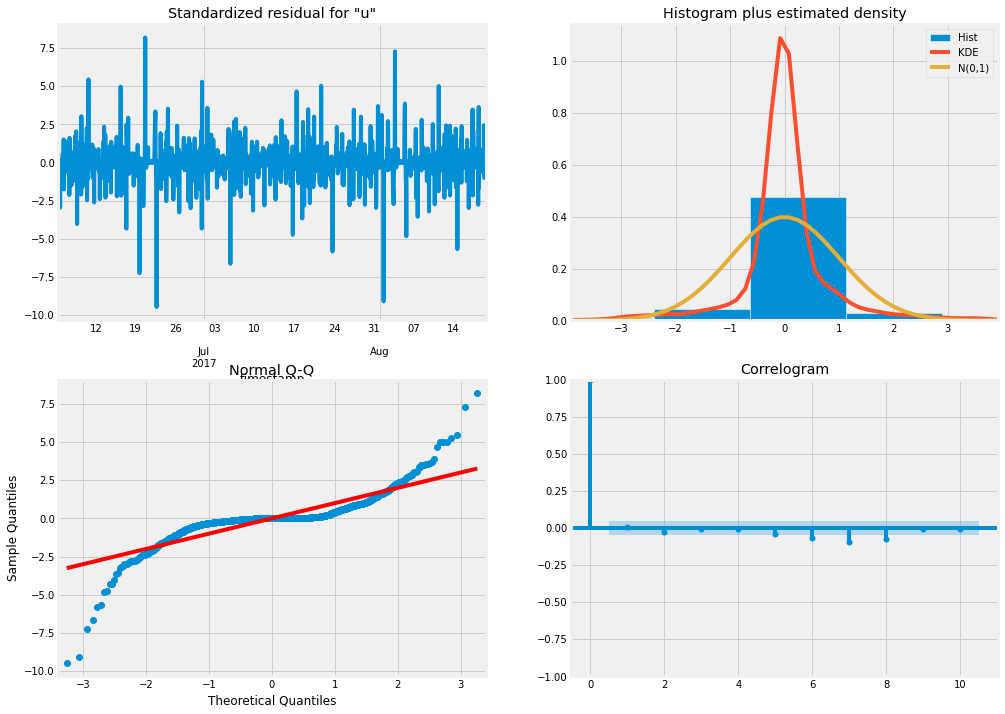

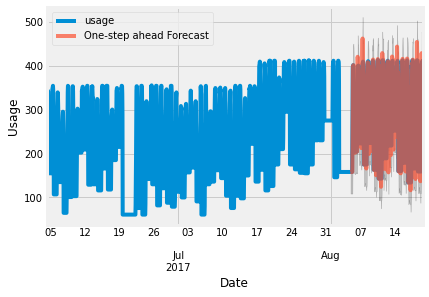

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:27240.02904057802
At iterate   25    f=  4.88780D+00    |proj g|=  8.26655D-02

At iterate   30    f=  4.88739D+00    |proj g|=  5.30109D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     56      1     1     0   5.301D-06   4.887D+00
  F =   4.8873895812213837     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Mac

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:22299.17039755002
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:23955.456932608635
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:22474.702435249266
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:21179.150434581625
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:21083.122272791938
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:24937.412375485503
   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     24      1     0     0   3.730D-08   7.116D+00
  F =   7.1162162035068048     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.55050D+00    |proj g|=  4.00706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of 

ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:22156.019076977773
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:20481.37337193291
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:22071.08884431843
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:20643.074420623794
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:19633.602559182887
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:19562.03015549163
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:19611.212130925705
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30185D+00    |proj g|=  6.01697D-01

At iterate    5    f=  6.16325D+00    |proj g|=  1.86043D-02

At iterate   10    f=  6.04075D+00    |proj g|=  6.37964D-02

At iterate   15    f=  6.03927D+00    |proj g|=  2.91797D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments exp

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:18672.619794684568
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:19471.17962793337
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:18819.83797622066
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:18280.082786131534
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:18164.687526034002
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:19390.804600276933
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:19251.136489102893
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.65152D+00    |proj g|=  9.65103D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:18510.28380473229
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:19270.29550946533
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:18650.691245786067
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:18258.52723143559
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:18076.50098900139
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:19619.05689693681
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:19466.82573480544
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:20669.693749999235
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24963D+00    |proj g|=  9.35062D-02

At iterate    5    f=  5.24433D+00    |proj g|=  9.39463D-03

At iterate   10    f=  5.21831D+00    |proj g|=  2.70860D-01

At iterate   15    f=  5.05818D+00    |proj g|=  2.52078D-01

At iterate   20    f=  5.04479D+00    |proj g|=  6.64615D-06

           * * *

T

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:18623.76783301631
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:19467.00537463316
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:18772.92437433456
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:18188.72236034386
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:18130.80906371226
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:19399.945181526484
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:19253.030830416843
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:20419.595851842583
At iterate    0    f=  5.32063D+00    |proj g|=  1.83963D-01

At iterate    5    f=  5.28422D+00    |proj g|=  8.96554D-02

At iterate   10    f=  5.28069D+00    |proj g|=  9.54369D-03

At iterate   15    f=  5.26083D+00    |proj g|=  1.63639D-01

At iterate   20    f=  5.14175D+00    |proj g|=  5.31526D-01

At iterate   25    f=  5.07573D+00    |proj g|=  1.49745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:18435.019654271942
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:19262.38141581991
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:18579.79298491691
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:18143.973722658506
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:18026.495140816252
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:19354.33015678347
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:19210.9046752801
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:20479.73729335436
At iterate   20    f=  5.02901D+00    |proj g|=  2.37285D-01

At iterate   25    f=  5.02372D+00    |proj g|=  7.94049D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25   

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:18487.870602410418
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:19210.904675713457
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:18630.432023169084
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:18247.885125795878
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:18076.403992486405
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:19338.13859270632
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:19200.335877203615
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:20464.754034646212
At iterate   20    f=  5.03868D+00    |proj g|=  1.52245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     27      1     0     0   7.190D-07   5.039D+00
  F =   5

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:18474.816735659944
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:19209.886504334027


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This p

ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:18630.221771661854
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:18237.0170415768


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:18079.29183978676


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0004      0.142      0.003      0.998      -0.278       0.278
ma.L1          4.6933      3.115      1.507      0.132      -1.412      10.799
ar.S.L12      -0.4712      0.014    -34.565      0.000      -0.498      -0.445
ma.S.L12      -0.9711      0.004   -227.802      0.000      -0.979      -0.963
sigma2        57.1020     75.702      0.754      0.451     -91.272     205.476


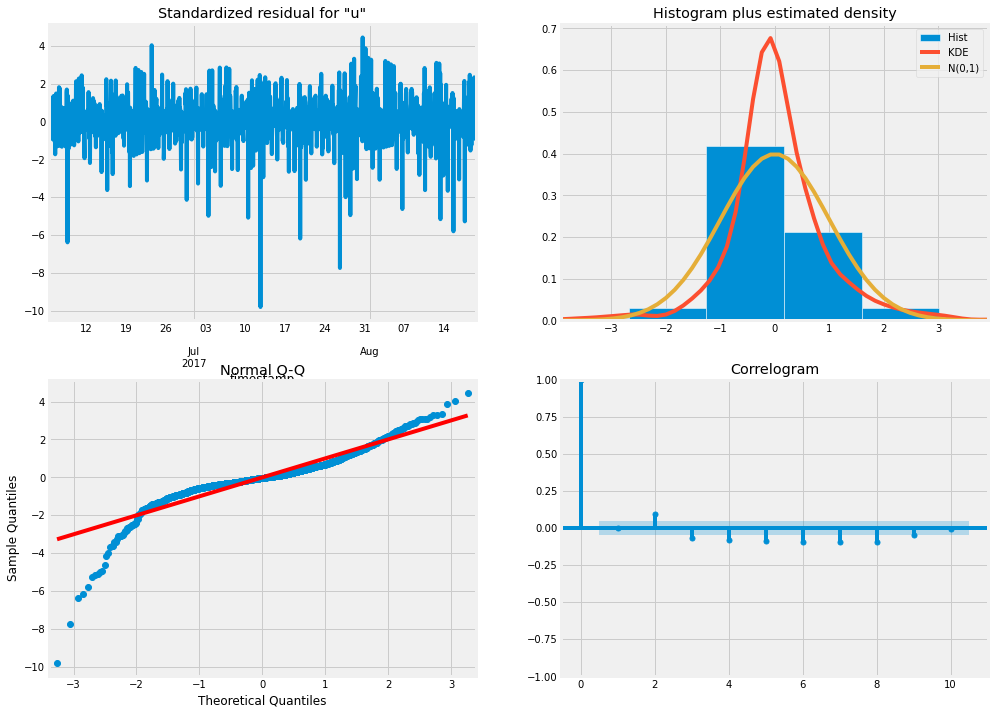

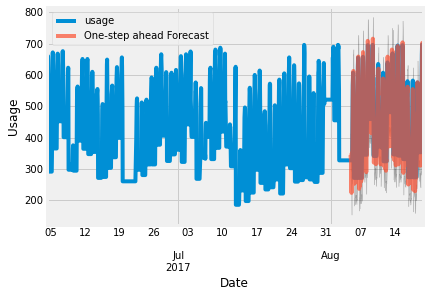

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:30028.987534483516
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     48      1     0     0   1.746D-05   5.035D+00
  F =   5.0345738101581095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23504D+00    |proj g|=  5.10869

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:29138.485088473964
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:27930.020733545833
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:26296.859918509115
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:27778.390405118076
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:26841.03858171335
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:25689.665576922533


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:25452.708059592143
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:27763.56847235267
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     20      1     0     0   3.106D-06   7.943D+00
  F =   7.9428803403691290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61397D+00    |proj g|=  1.37404D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of functi

ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:25964.483801456474
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:24397.542772687782
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:25797.78225130605
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:24551.081272577885
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:23959.575432487683
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:23758.770326397254
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:23254.369574031793

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.39229D+00    |proj g|=  6.16263D-01

At iterate    5    f=  7.22167D+00    |proj g|=  6.81334D-03

At iterate   10    f=  7.22162D+00    |proj g|=  7.42746D-03

At iterate   15    f=  7.21823D+00    |proj g|=  8.07297D-02

At iterate   20    f=  7.10064D+00    |proj g|=  2.74043D-01

At iterate   25    f=  7.07756D+00    |proj g|=  1.47518D-04

       

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:22283.416237331032
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:23100.76490310763
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:22446.99502628995
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:21990.364341657303
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:21795.366988723697
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:23006.80515116288
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:22844.439158220277
Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29443D+00    |proj g|=  6.06803D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2  

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:22105.891895985777
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:22867.547746966266
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:22268.866166161017
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:21970.365834826385
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:21714.205912643283
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:23263.62812678132
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:23092.38236653083
Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57313D+00    |proj g|=  6.93870D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2 

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:22248.382469197702
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:23092.35705168268
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:22415.264059387515
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:21933.90207569668
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:21774.06609001272
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:23008.100207481322
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:22841.602754730207
At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62630D+00    |proj g|=  3.62789D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   3.628D-05   6.626D+00
  F =   6.6263

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:22049.07253880878
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:22853.0897382276
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:22211.537864985432
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:21899.32588315058
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:21681.55153973735
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:22972.829319788947
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:22809.32093677871
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   1.665D-04   6.548D+00
  F =   6.5483747662332101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:22091.194065645526
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:22809.258315031777
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:22253.766986712977
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:21957.190364778868
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:21719.719363647928
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:22960.390106477487
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:22798.81344451879
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:24063.868573771753
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.801D-06   6.563D+00
  F =   6.5629624088532807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate 

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:22075.11098744163
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:22810.35090688884
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:22239.29408372756
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:21947.287970424502
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:21705.310884463266
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3399      0.183      1.853      0.064      -0.020       0.699
ma.L1         -0.1344      0.190     -0.707      0.479      -0.507       0.238
ar.S.L12      -0.4454      0.013    -34.687      0.000      -0.471      -0.420
ma.S.L12      -1.0160      0.005   -224.939      0.000      -1.025      -1.007
sigma2      9091.8245    141.851     64.094      0.000    8813.801    9369.848


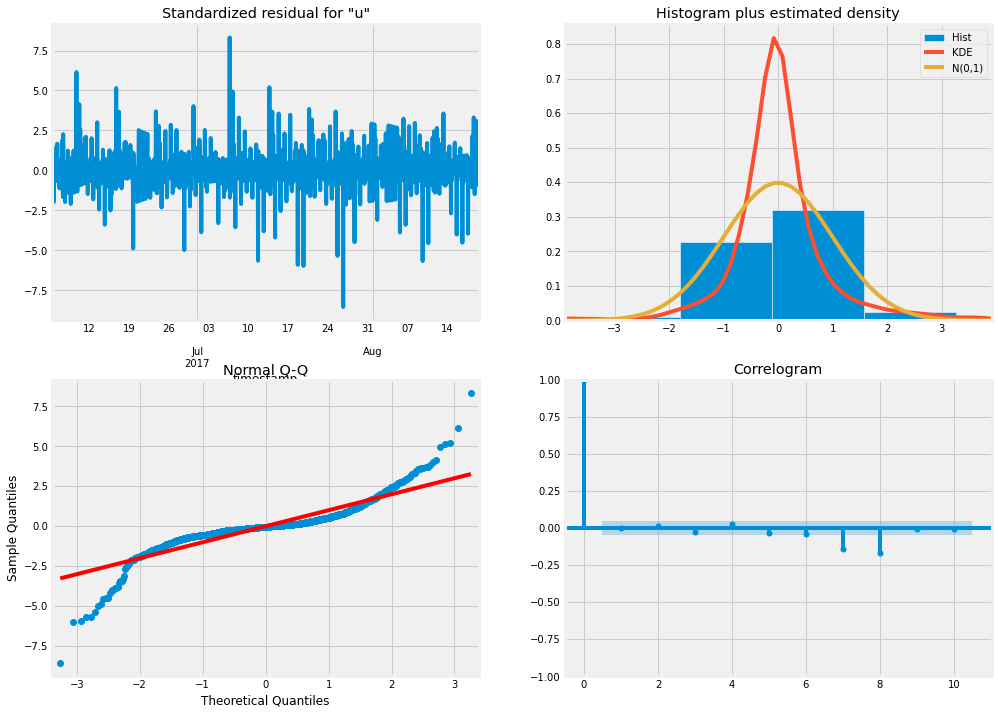

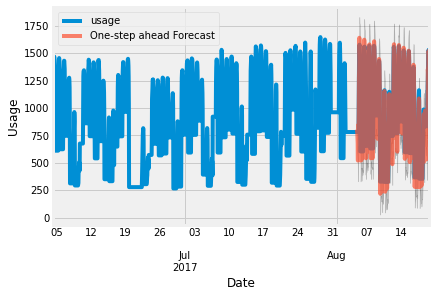

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:32879.402864237156
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.21256D+00    |proj g|=  1.00811D-01

At iterate    5    f=  6.20822D+00    |proj g|=  3.50293D-03

At iterate   10    f=  6.20738D+00    |proj g|=  5.39131D-02

At iterate   15    f=  6.20122D+00    |proj g|=  2.25863D-01

At iterate   20    f=  6.03494D+00    |proj g|=  1.44458D-01

At iterate   25    f=  6.01612D+00    |proj g|=  7.73916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact 

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:31968.359168040704
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:30789.504298000313
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:29283.370149625604
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:30635.951719273537
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:29760.60288643541
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:28733.046493557682
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:28531.919195527327
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:30601.470753881644
At iterate   15    f=  8.73704D+00    |proj g|=  1.95985D-01

At iterate   20    f=  8.71438D+00    |proj g|=  1.40458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     

ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:28804.295551589676
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:27351.31536194039
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:28637.199628069924
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:27511.566411274034
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:26960.168847438305
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:26799.483152230023
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     43      1     0     0   1.381D-05   8.112D+00
  F =   8.1123827096385206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17329D+00    |proj g|=  6.18410D-01

At iterate    5    f= 

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:25108.33308870654
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:25911.12390138918
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:25296.56236973076
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:24874.45377772076
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:24679.808803246528
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:25842.03939526395
    1      1      2      1     0     0   8.565D-06   7.113D+00
  F =   7.1128621641496679     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06009D+00    |proj g|=  5.52846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm o

ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:26919.45608199951
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:24924.985283865673
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:25678.726853346427
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:25113.227312179035
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:24851.78665707748
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:24582.663487035166
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:26106.17006253921
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:25903.060682396695
   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      8      1     0     0   6.151D-05   6.992D+00
  F =   6.9919564117281405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33919D+00    |proj g|=  6.34834D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = tota

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:25079.855626664445
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:25903.036226809687
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:25397.330595091244
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:24823.309367918366
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:24665.717586211234
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:25847.118168450474
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:25651.1995119021
           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.39461D+00    |proj g|=  3.71119D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Pro

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:24878.407229701457
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:25664.226757745924


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:25067.28321435478
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:24786.64693902612
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:24558.753015455353
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:25814.564917079326
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:25622.65780335996
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   7.185D-05   7.316D+00
  F =   7.3157684477334293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06206D+00    |proj g|=  2.66887D-01

At iterate    5    f=  6.97454D+00    |proj g|=  7.13406D-02

At iterate   10    f=  6.97299D+00    |proj g|=  1.61945D

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:24916.43675442344
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:25622.486702708942
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:25103.43136925927
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:24836.670749815516
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:24590.436839128746
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:25800.054527911434
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:25611.00080941095
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.794D-06   7.331D+00
  F =   7.3310889774799239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98406D+00    |proj g|=  1.08312D-01

At iterate    5    f=  6.97820D+00    |proj g|=  1.26855D-02

At iterate 

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:24896.250009344825
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:25624.08924926835


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:25086.238010346096
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:24824.532993347155
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:24572.065482865964
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3357      0.207      1.625      0.104      -0.069       0.741
ma.L1         -0.1147      0.214     -0.535      0.593      -0.535       0.305
ar.S.L12      -0.4135      0.012    -34.191      0.000      -0.437      -0.390
ma.S.L12      -1.0000      0.013    -74.106      0.000      -1.026      -0.974
sigma2      4.538e+04   2.98e-07   1.52e+11      0.000    4.54e+04    4.54e+04


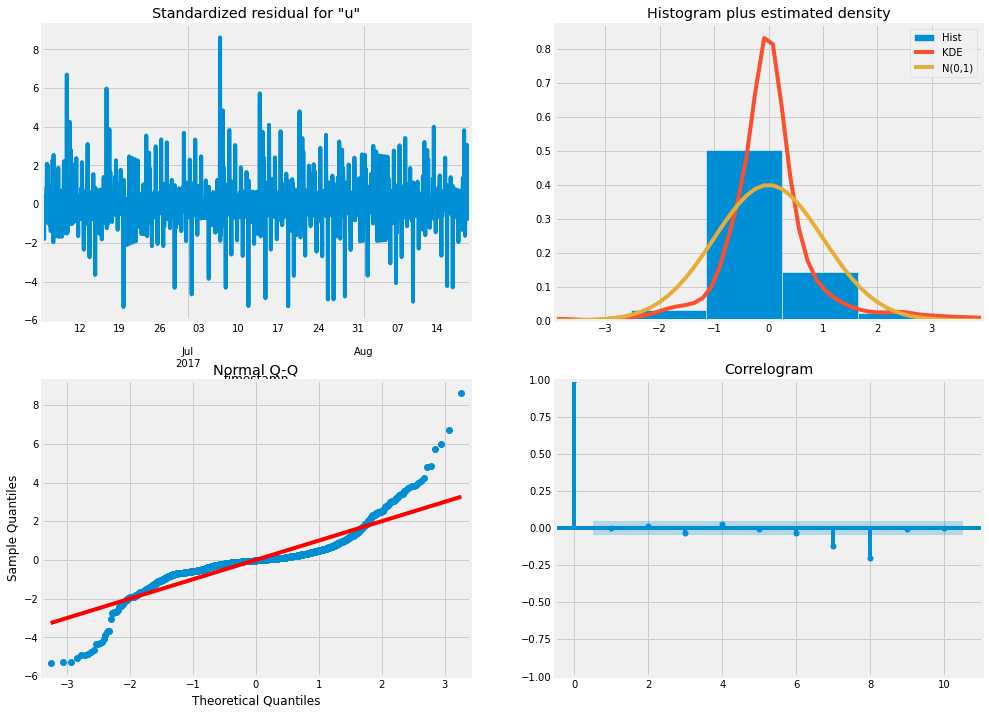

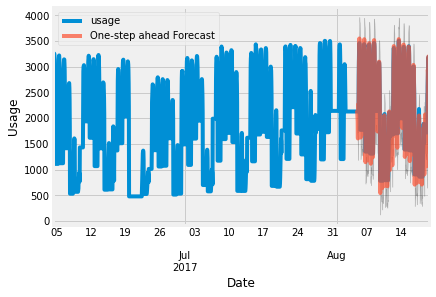

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:23041.602281973726
    3      5      9      1     0     0   3.321D-06   7.327D+00
  F =   7.3265613660760351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.97948D+00    |proj g|=  1.08878D-01

At iterate    5    f=  6.97347D+00    |proj g|=  9.42581D-03

At iterate   10    f=  6.97326D+00    |proj g|=  8.15416D-03

At iterate   15    f=  6.97218D+00    |proj g|=  1.88579D-02

At iterate   20    f=  6.92643D+00    |proj g|=  2.09571D-01

At iterate   25    f=  6.78560D+00    |proj g|=  2.06824D-02

At iterate   30    f=  6.78524D+00    |proj g|=  2

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:22761.384818670183
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:23189.451510664083
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:21025.7701431424
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:22561.84333355571
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:21163.96980085443
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:19981.20678820582
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:19948.61872897931
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:21135.254454342823
At iterate    0    f=  6.24004D+00    |proj g|=  4.22343D-01

At iterate    5    f=  6.20526D+00    |proj g|=  2.22096D-02

At iterate   10    f=  6.20430D+00    |proj g|=  7.87844D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit

ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:21414.254539710957
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:19375.637065464965
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:20750.53617633947


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:19506.365089791154
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:18603.4981956765
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:18558.16764098101
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:18994.880602161084
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   2.596D-07   5.694D+00
  F =   5.6938248329006136     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05078D+00    |proj g|=  5.72985D-01

At iterate    5    f=  5.94102D+00    |proj g|=  4.39631D-03

At iterate   10    f=  5.91990D+00    |proj g|=  3.15383D-01

At iterate  

ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:20130.27550870161
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:18152.295767750256
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:18878.108283610753
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:18277.370594754768
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:17756.71511780958
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:17717.893192671043
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:18810.64668987433
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:18688.256394879965
At iterate    5    f=  5.14308D+00    |proj g|=  3.11913D-03

At iterate   10    f=  5.14306D+00    |proj g|=  3.42135D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:18011.621304946457
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:18706.799237907464


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2

ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:18134.136698995528
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:17722.609351821196
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:17683.794142415234
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:18956.575519088237
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:18830.223441781796
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:20056.124846182778
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      6      1     0     0   1.233D-05   5.438D+00
  F =   5.4377527872452607     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0   

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:18070.12411653067
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:18830.08985475285
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:18197.671880348367
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:17622.942941801906
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:17594.633219365205
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:18750.32740317483
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:18625.103698761683
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:19836.19752945736
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12069D+00    |proj g|=  4.10448D-02

At iterate    5    f=  5.12005D+00    |proj g|=  2.10402D-02

At iterate   10    f=  5.08193D+00    |proj g|=  3.82955D-01

At iterate   15    f=  4.92791D+00    |proj g|=  1.49175D-01

At iterate   20    f=  4.92479D+00    |proj g|=  6.77076D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:17887.559107256122
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:18634.05686491957
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:18014.895572324265
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:17548.198945070966
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:17535.600564273715
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:18782.20288454117
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:18658.333471469206
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:19921.112238430982
At iterate    5    f=  5.07160D+00    |proj g|=  1.27076D-02

At iterate   10    f=  5.01394D+00    |proj g|=  2.52328D-01

At iterate   15    f=  4.87452D+00    |proj g|=  1.31678D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N   

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:17998.602018803183
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:18658.331222749395
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:18122.671450487866
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:17713.148864494993
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:17687.31897258437
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:18769.394037666214
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:18648.253154767397
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:19908.699746264
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     28      1     0     0   1.593D-05   4.905D+00
  F =   4.9052895362058839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:17990.11675558488
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:18657.500018346374
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:18112.124034529348
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:17717.872751480652
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:17687.167572684975
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9633      0.009   -105.265      0.000      -0.981      -0.945
ma.L1          1.0000      1.144      0.874      0.382      -1.243       3.243
ar.S.L12      -0.7819      0.007   -110.453      0.000      -0.796      -0.768
ma.S.L12      -0.2110      0.023     -9.108      0.000      -0.256      -0.166
sigma2      1033.2404   1180.002      0.876      0.381   -1279.520    3346.001


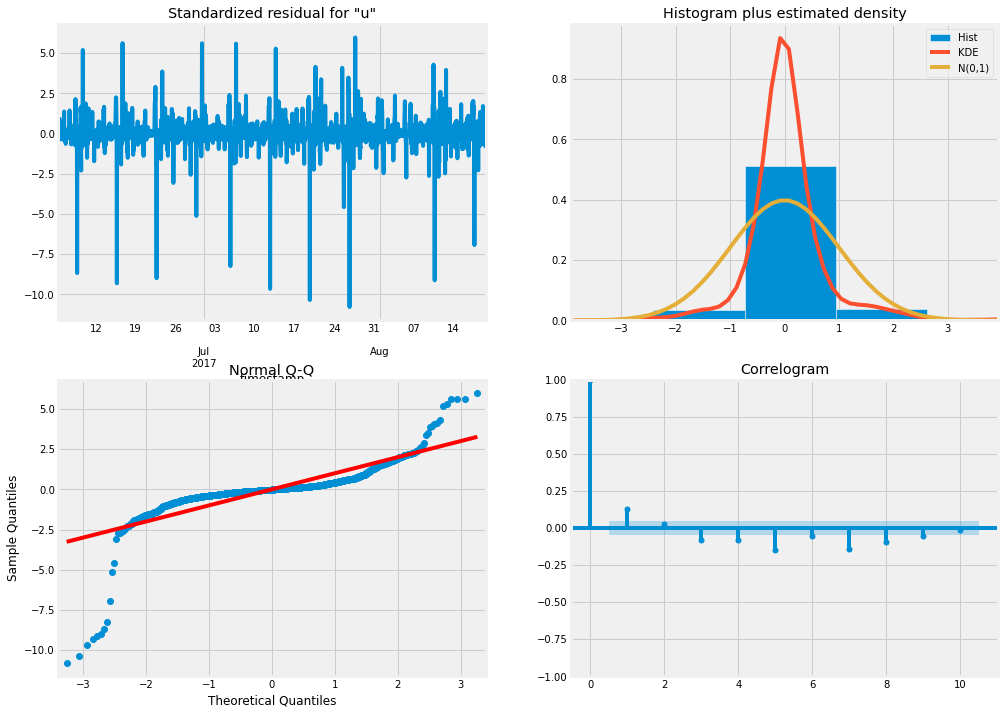

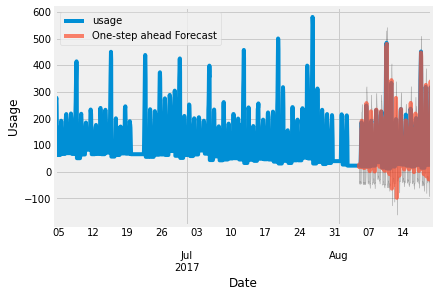

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:29982.56632905188
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:28854.800495745585
   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     78      1     0     0   2.742D-05   4.902D+00
  F =   4.9024309584473498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08443D+00    |proj g|=  5.55279D-03

At iterate    5    f=  5.08438D+00    |proj g|=  2.94890D-05

At iterate   10    f=  5.08438D+00    |proj g|=  9.85345D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of s

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:25301.43318281066
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:26775.535772404288
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:25478.374288218205
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:24230.470285543146
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:24096.370247020095
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:27716.095774099485
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:26688.67291192476
At iterate    0    f=  7.31718D+00    |proj g|=  1.84905D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   4.867D-06   7.317D+00
  F =   7.3171703437191846     

CONVERGENCE: NORM_OF_PROJECTED_GR

ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:23559.881711708764
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:24981.28422034701
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:23724.01681620753
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:22754.73599961673
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:22669.565151656254
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:22502.567468070418
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:22348.15140824145
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     22      1     0     0   1.376D-06   6.831D+00
  F =   6.8314611162753467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

         

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:21652.420890088688
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:22359.41896410756
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:21804.386837452817
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:21398.513835083482
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:21301.913403401923
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:22321.994238538875
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:22175.33809373744
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:23438.24483115838
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   3.070D-07   6.438D+00
  F =   6.4377610829039522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:21524.361413623243
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:22197.712797392425
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:21672.666198062132
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:21389.62641443355
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:21249.815958569994
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:22512.983285817994
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:22355.32663606447
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:23551.960842369554
At iterate   20    f=  5.86676D+00    |proj g|=  7.22096D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     30      1     0     0   3.615D-06   5.867D+00
  F =   5.

ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:22355.313359147338
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:21771.787877479877
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:21303.329205960035
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:21249.378666708588
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:22330.825358635142
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:22178.875925166212
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:23339.298591857565
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:21464.30949375061
   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     41      1     0     0   6.330D-06   5.891D+00
  F =   5.8911166130211798     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49866D+00    |proj g|=  8.99023D-01

At iterate    5    f=  6.09611D+00    |proj g|=  9.42131D-02

           * * *

Tit   = total number of iter

ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:21618.273251991
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:21276.384497985877
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:21192.36098039122
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:22295.746765199117
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:22146.843180512846
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:23412.65010118114
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:21512.110538319517
           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45351D+00    |proj g|=  8.99377D-01

At iterate    5    f=  6.04844D+00    |proj g|=  2.61633D-01

At iterate   10    f=  6.04745D+00    |proj g|=  1.16605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of th

ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:21661.93292219376
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:21377.81371248736
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:21254.813769291264
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:22280.172414695342
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:22134.811620950288
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:23397.11082083417
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:21498.7799426362
At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03622D+00    |proj g|=  3.12525D-03

At iterate    5    f=  6.03622D+00    |proj g|=  1.92455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     

ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:21647.323900339114
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:21367.87798056172
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:21294.150329932396
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9178      0.132     -6.964      0.000      -1.176      -0.660
ma.L1          1.1037      0.170      6.485      0.000       0.770       1.437
ar.S.L12      -0.5715      0.010    -55.117      0.000      -0.592      -0.551
ma.S.L12      -1.4615      0.023    -64.866      0.000      -1.506      -1.417
sigma2      2923.3853    952.780      3.068      0.002    1055.970    4790.801


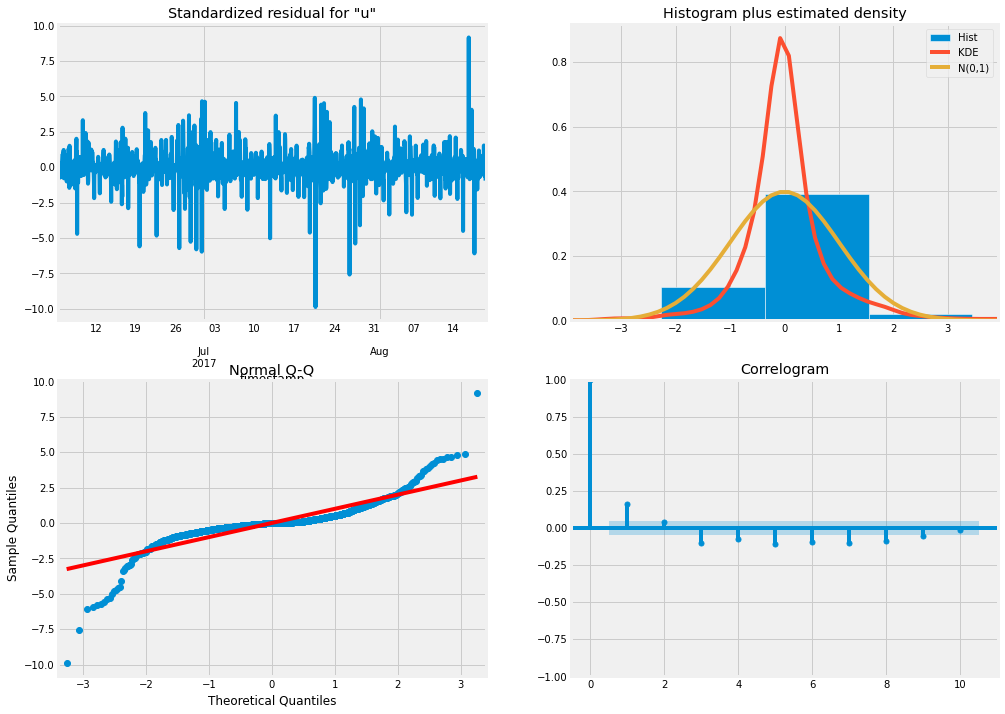

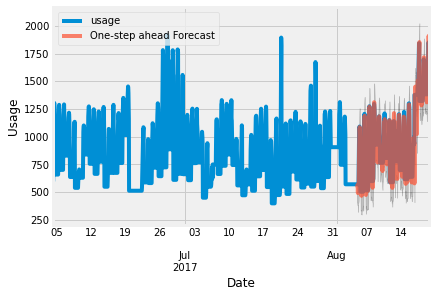

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:30260.792160432382
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:29214.10578448598
At iterate    5    f=  6.03544D+00    |proj g|=  2.43431D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     10      1     0     0   2.434D-05   6.035D+00
  F =   6.0354356019115185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine p

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:25297.58001651174
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:27299.870219572513
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:26134.451347023678
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:23649.159698390205
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:23542.125743707136
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:27987.663903901495
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:27037.296015468444
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:25518.449949644946
    1      1      2      1     0     0   5.846D-06   7.467D+00
  F =   7.4672915931803674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11867D+00    |proj g|=  1.45781D-01

At iterate    5    f=  7.09586D+00    |proj g|=  6.44705D-02

At iterate   10    f=  7.09437D+00    |proj g|=  1.58165D-02

At iterate   15    f=  7.03489D+00    |pro

ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:23523.7644287106
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:25418.92866852092
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:23686.95241439848
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:22177.536062035473
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:22098.771854871753
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:22991.64111526947
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:22832.48415164741
           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07636D+00    |proj g|=  7.10872D-01

At iterate    5    f=  6.89874D+00    |proj g|=  7.27160D-03

At iterate   10    f=  6.89757D+00    |proj g|=  5.56903D-02

At iterate   15    f=  6.45162D+00    |proj g|=  2.54752D-01

At iterate   20    f=  6.41984D+00    |proj g|=  1.83328D-01

At iterate   25    f=  6.41161D+00    |proj g|=  3.70830D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tni

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:21888.995039493908
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:22844.026804047688
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:22044.77208131835
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:20873.008491274624
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:20853.535895532623
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:22784.48820440296
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:22632.26555572029
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:23893.963055897428
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14523D+00    |proj g|=  8.75627D-02

At iterate    5    f=  6.14361D+00    |proj g|=  1.23044D-02

At iterate   10    f=  6.06536D+00    |proj g|=  5.76873D-01

At iterate   15    f=  5.97203D+00    |proj g|=  1.67398D-01

At iterate   20    f=  5.96647D+00    |proj g|=  3.19000D-05

           * * *

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:21734.116360641885
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:22655.179748590526
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:21884.16601745604
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:20865.62581172314


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:20833.989797439397
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:22998.767290556993
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:22838.235619411018
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:24035.936145750187
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     26      1     0     0   3.130D-05   5.924D+00
  F =   5.9236958453222153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17645D+00    |proj g|=  7.03753D-02

           * * *

Tit   = total number of iterations
Tnf   = total n

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:21833.797245093025
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:22838.218579176966
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:21991.130080241957
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:20774.866417508198


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:20771.52691776593
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:22790.53094256721
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:22633.727893818563
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:23799.62132462726
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     39      1     0     0   9.727D-06   5.951D+00
  F =   5.9508716589675643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60890D+00    |proj g|=  8.72728D-01

At iterate    5    f=  6.22484D+00    |proj g|=  1.66286D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total n

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:21648.88873091159
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:22645.139539721004
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:21802.52320349591
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:20749.536561261564
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:20734.662694941926
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:22748.70352915214
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:22594.292451997142
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:23857.764122618155
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     38      1     0     0   1.550D-05   5.900D+00
  F =   5.8999151392888738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.55523D+00    |proj g|=  8.70063D-01

At iterate    5    f=  6.17586D+00    |proj g|=  5.40512D-01



ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:21712.721780906148
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:22594.27727700323
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:21863.78418738293
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:20854.021779465656
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:20843.98441150401
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:22730.621401171655
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:22579.972020928755
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:23839.29314774258
    3     20     25      1     0     0   3.495D-05   5.918D+00
  F =   5.9178630809449695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15821D+00    |proj g|=  2.24840D-03

At iterate    5    f=  6.15820D+00    |proj g|=  2.47634D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = t

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:21695.984194790766
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:22591.383465334246
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:21845.497164961493
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:20839.8190301351
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:20824.44518968867
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9667      0.007   -139.461      0.000      -0.980      -0.953
ma.L1          1.0000      0.581      1.723      0.085      -0.138       2.138
ar.S.L12      -0.8866      0.006   -141.641      0.000      -0.899      -0.874
ma.S.L12      -0.1013      0.039     -2.587      0.010      -0.178      -0.025
sigma2      5867.1164   3394.034      1.729      0.084    -785.068    1.25e+04


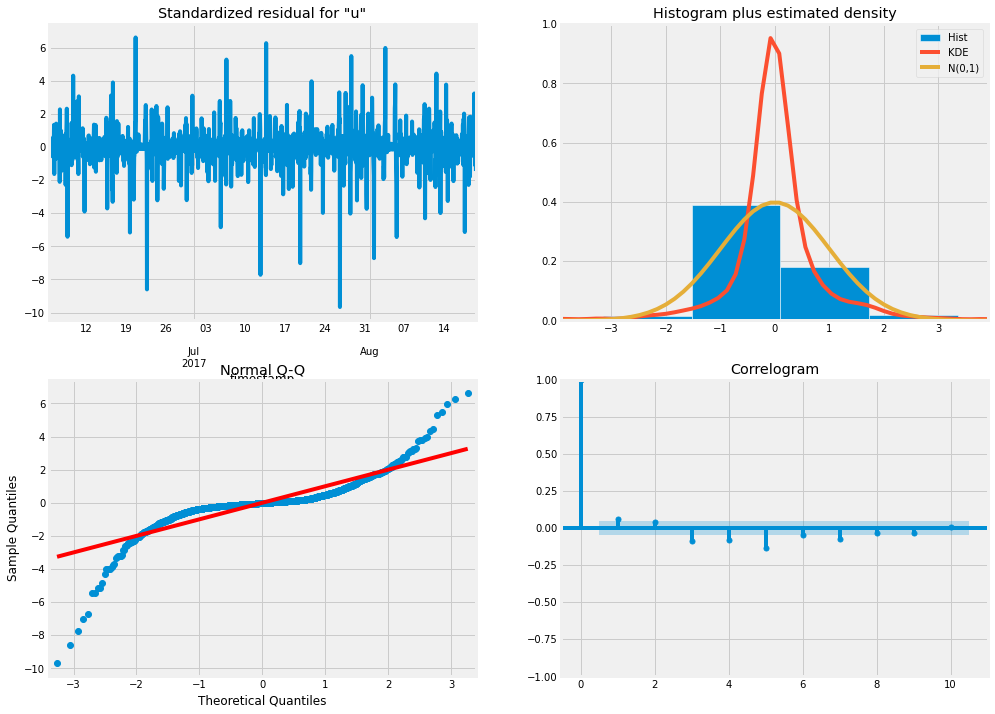

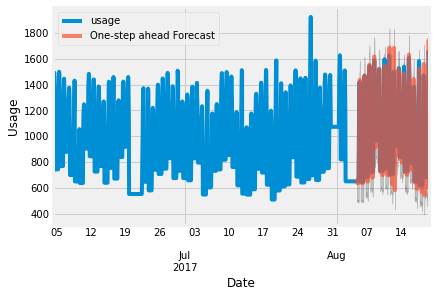

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:29800.818925261112
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:28840.26660581574
   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     68      1     0     0   4.668D-05   5.913D+00
  F =   5.9127546877837425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15694D+00    |proj g|=  6.62892D-03

At iterate    5    f=  6.15687D+00    |proj g|=  2.82537D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:25590.681780679886
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:27239.9676311643
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:26228.493083217152
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:24614.731344231273
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:24400.30735936389
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:27541.402090691037
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:26676.105119465814


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   5.803D-06   7.460D+00
  F =   7.4597456340795221     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17938D+00    |proj g|=  2.16525D-01

At iterate    5    f=  7.12084D+00    |proj g|=  4.69710D-03

At iterate   10    f=  7.12082D+00    |proj g|=  7.68334D-03

At iterate   15    f=  7.11977D+00    |proj g|=  7.78532D-02

At iterate   20    f=  7.06168D+00    |proj g|=  1.79140D-01


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:23717.91086470317
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:25317.295024667117
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:23886.176558414103
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:22862.343844292824
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:22683.282930174864
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:22805.14157801409
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:22639.914865660838
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     40      1     0     0   6.082D-06   6.936D+00
  F =   6.9360664723721763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08407D+00    |proj g|=  6.98581D-01

At ite

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:21687.949478398492
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:22651.351906631735
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:21853.199617483624
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:20728.186093098408
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:20702.604486604665
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:22628.354642161343
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:22470.646776453497
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:23734.40683322212
At iterate    0    f=  6.51771D+00    |proj g|=  3.46965D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   5.329D-10   6.518D+00
  F =   6

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:21544.70459945581
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:22493.46515419148
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:21706.37545494666
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:20713.58060818869
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:20673.081967451286
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:22815.36379936098
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:22644.30110677136
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:23856.959332133847
At iterate   15    f=  5.92258D+00    |proj g|=  2.61594D-01

At iterate   20    f=  5.87216D+00    |proj g|=  1.27879D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23   

ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:22644.27969864219
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:21818.89464087641
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:20677.578155635165
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:20670.30753908919
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:22634.218306591167
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:22470.195357987333
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:23648.78826782175
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     42      1     0     0   6.103D-05   5.901D+00
  F =   5.9005070499265431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:21484.95764769258
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:22481.491285528245


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:21649.047917431166
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:20651.93763252139
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:20738.58671948551
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:22609.02251351053
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:22448.421239601295
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:23715.946480130897
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     40      1     0     0   3.151D-05   5.855D+00
  F =   5.8552229137656981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:21532.695293119592
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:22448.42123952322
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:21694.858421248744
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:20698.188023683542
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:20768.277082738736
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:22590.593499090333
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:22434.090175430283
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:23686.33620996977
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   1.463D-04   5.869D+00
  F =   5.8687827952888743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 

ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:21505.809251662824
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:22445.422520039956


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:21673.649922990528
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:20676.08873263462
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:20751.4992362635
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3926      0.178      2.201      0.028       0.043       0.742
ma.L1         -0.2084      0.188     -1.108      0.268      -0.577       0.160
ar.S.L12      -0.5953      0.012    -51.068      0.000      -0.618      -0.572
ma.S.L12      -1.0195      0.005   -194.850      0.000      -1.030      -1.009
sigma2      5330.2518    100.835     52.861      0.000    5132.619    5527.884


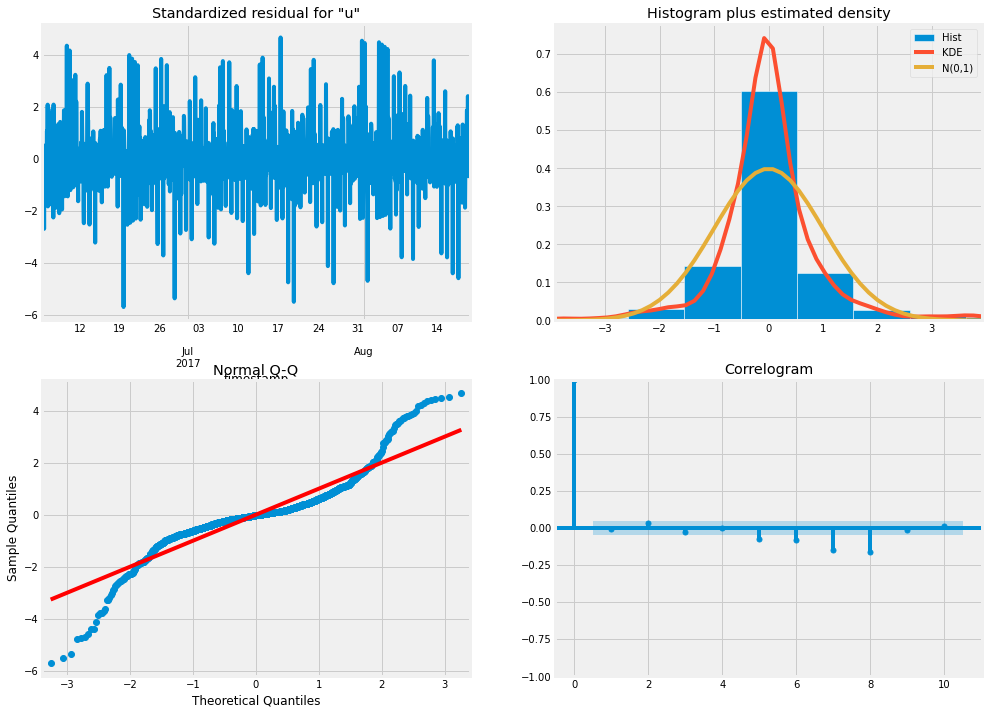

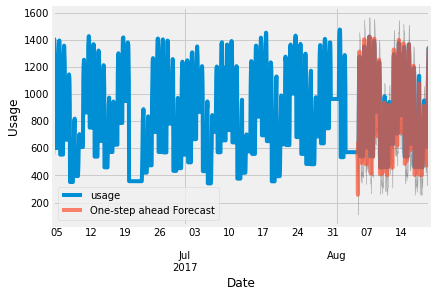

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:28238.3562656221
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:27280.833017283512
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   1.064D-05   5.861D+00
  F =   5.8609076476725255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11713D+00    |proj g|=  5.39448D-03

At iterate    5    f=  6.11707D+00    |proj g|=  6

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:23580.903595955748
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:25572.333949380998
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:23734.512255561353
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:21981.820756206067
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:21900.615906365565
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:25992.13971367178
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:25132.409526367614
At iterate    0    f=  7.00216D+00    |proj g|=  2.54444D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   1.910D-07   7.002D+00
  F =   7.0021470244251622     

CONVERGENCE: NORM_OF_PROJECTED_G

ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:23828.992159361867
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:21824.869916152842
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:23705.075454792357


/home/irem/anaconda3/envs/rapids-21.10/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:21968.37709089872
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:20503.822056821253
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:20446.708105113983
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:21301.56321389298
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:21161.263529451462
At iterate   15    f=  6.49536D+00    |proj g|=  1.71802D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     23      1     0     0   4.948D-06   6.495D+00
  F =   6.4953631841226462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:20232.95822459767
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:21171.883330333905
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:20368.512491463007
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:19186.98481797121
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:19169.22064579858
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:21115.134251539544
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:20979.552377183245
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:22238.702108805184

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11211D+00    |proj g|=  6.49837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3 

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:20095.960457854108
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:21000.617667714687
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:20227.172124792494


In [ ]:
municipality_ids = hourly_data.municipality_id.unique()
for mun_id in municipality_ids:
    mun_data = create_municipality_based_data(mun_id)
    crete_arima_model(mun_data)